# Análisis numérico

Proyecto realizado para la materia Análisis Numérico. Resolución numérica de ecuaciones diferenciales en dos dimensiones a través de un esquema FEM en Julia.

## FEM 2D: Problemas de reacción-difusión singularmente perturbados

El objetivo es resolver el siguiente problema de reacción-difusión con condiciones de Dirichlet homogéneas:

$$
\begin{cases}
-\varepsilon^2 \Delta u + u = f & \Omega = [0,1]² \\
u = 0 & \Gamma = \partial \Omega
\end{cases}
$$

Supongamos que se toma $f$ tal que

$$
u(x,y) = (1-e^{-(\frac{1-x}{\varepsilon})})(1-e^{-(\frac{1-y}{\varepsilon})})(1-e^\frac{-x}{\varepsilon})(1-e^\frac{-y}{\varepsilon})
$$

Es solución. Notemos que dicha funcion se anula en $\Gamma$.

### Resolución

Primero utilizando el paquete de $\texttt{DelunayTriangulation}$ se implementó una función que dada una cantidad $N$ de subdivisiones del intervalo [0,1] retorna: la matriz de vértices, $\texttt{nodes\_ mesh}$; la matriz de elementos, $\texttt{triangles\_ mesh}$ 

In [1]:
# Triangulación

using DelaunayTriangulation, CairoMakie, LinearAlgebra, Plots

function nodes_mesh(mesh)  #Devuelve una matriz con los nodos de una triangulación
    v = get_points(mesh)
    N = length(v)
    A = zeros(N, 2)
    for i in 1:N
        A[i,1] = v[i][1]
        A[i,2] = v[i][2]
    end
    return A
end

function triangles_mesh(mesh) #Devuelve una matriz con los triangulos de una triangulación
    S = get_triangles(mesh)
    N = length(S)
    A = zeros(Int, N, 3)
    for i in 1:N
        a = pop!(S)
        for j in [1,2,3]
            A[i,j] = a[j]
        end
    end
    return A
end

function boundary_nodes(mesh) #Devuelve un vector con los índices de los nodos del borde
    A = nodes_mesh(mesh)

    a = minimum(A[:,1]) #marco los bordes
    b = maximum(A[:,1])
    c = minimum(A[:,2])
    d = maximum(A[:,2])

    bordes = Set() #porque no se como va a ser el largo y el orden no me va a importar
    for i in 1:(length(A[:,1]))
        if (abs(A[i,1]-a) < 10^-10) || (abs(A[i,1]-b) < 10^-10) || (abs(A[i,2]-c) < 10^-10) || (abs(A[i,2]-d) < 10^-10)
            #para ver si pertenece al borde, me fijo si x es a ó b, o si y es c ó d
            push!(bordes, i)
        end
    end

    N = length(bordes)
    v = zeros(Int, N) #vectorizo el Set
    for i in 1:N
        v[i] = pop!(bordes)
    end

    return v
end

#Juntando todo, poniendo un rectangulo [a,b]x[c,d] y N vértices por lado,
# devuelve una matriz con nodos, una con los triángulos y un vector con los índices de borde
function generate_mesh(a, b, c, d, N)
    mesh = triangulate_rectangle(a, b, c, d, N, N,delete_ghosts = true)
    return nodes_mesh(mesh), triangles_mesh(mesh), boundary_nodes(mesh)
end

using GLMakie

function plot_u(nodes,u)
    z = [u(x,y) for x in nodes[:,1], y in nodes[:,2]]
    #donde u es la solución exacta
    GLMakie.surface(nodes[:,1],nodes[:,2],z,axis=(type=Axis3,))
end

#funcion para graficar uh
function plot_uh(nodes,elements,uh)
    nodes3 = hcat(nodes, uh)
    fig = Figure()
    ax = Axis3(fig[1,1])
    mesh!(ax, nodes3, elements, color = uh)
    fig
end

plot_uh (generic function with 1 method)

In [2]:
N = 50 #Elijo un N cualquiera

nodos, tri, bordes = generate_mesh(1.0, 0.0, 1.0, 0.0, N)

([1.0 1.0; 0.9795918367346939 1.0; … ; 0.020408163265306145 1.1102230246251565e-16; 1.1102230246251565e-16 1.1102230246251565e-16], [981 982 1031; 1685 1636 1686; … ; 2337 2288 2338; 2362 2363 2412], [2050, 2498, 35, 2494, 1900, 1651, 2493, 2350, 251, 2496  …  1451, 47, 1751, 1950, 3, 2478, 701, 1450, 2468, 2469])

In [21]:
tri

4802×3 Matrix{Int64}:
  981   982  1031
 1685  1636  1686
 1433  1434  1483
 1974  1925  1975
 2222  2223  2272
 1016   967  1017
 2422  2423  2472
 1947  1948  1997
  678   629   679
  306   307   356
    ⋮        
 1456  1457  1506
  910   911   960
 1294  1245  1295
 1065  1016  1066
 2321  2272  2322
  781   782   831
  162   163   212
 2337  2288  2338
 2362  2363  2412

In [3]:
u(x,y, eps) = (1-exp(-(1-x)/eps))*(1-exp(-(1-y)/eps))*(1-exp(-x/eps))*(1-exp(-y/eps))

eps = [1, 0.1, 0.01, 0.001]

4-element Vector{Float64}:
 1.0
 0.1
 0.01
 0.001

In [4]:
function u1(x,y)
    return u(x,y,1.0)
end

plot_u(nodos, u1)

In [5]:
function u2(x,y)
    return u(x,y, 0.1)
end

plot_u(nodos, u2)

In [6]:
function u3(x,y)
    return u(x,y, 0.001)
end

plot_u(nodos, u3)

In [7]:
using SparseArrays, Polynomials

In [8]:
function f(x,y,eps)
    u_xx = (1/eps^2)*(1-exp(-(1-y)/eps))*(1-exp(y/eps))*(exp(-(x+y)/eps))*(exp((2*x-1)/eps)+1)
    u_yy = (1/eps^2)*(1-exp(-(1-x)/eps))*(1-exp(x/eps))*(exp(-(x+y)/eps))*(exp((2*y-1)/eps)+1)
    return -eps^2*(u_xx+u_yy)+u(x,y,eps)
end

f (generic function with 1 method)

In [10]:
function ElementosFinitosRectanguloDir(f,N,eps)
    nodos, triangulos, bordes = generate_mesh(0.0, 1.0, 0.0, 1.0, N)
    n = size(nodos,1)
    K = spzeros(n,n)
    M = spzeros(n,n)
    F = zeros(n)
    Mmoño = spzeros(n,n)

    for tri in 1:length(triangulos[:,1])
        T = triangulos[tri,:]
        v = [nodos[i,:] for i in T] #busco el valor de los vertices
        B = hcat(v[2]-v[1], v[3]-v[1])
        medidaT = abs(det(B))/2 #para hacer la traslación al triangulo de referencia
        Mmoño_el = medidaT* [1/6 1/12 1/12
                             1/12 1/6 1/12
                             1/12 1/12 1/6]
        C = [-1 1 0
             -1 0 1]
        M_el = medidaT * C' * (inv(B)*inv(B')) *C

        m = 0.5*[v[1]+v[2] v[2]+v[3] v[3]+v[1]] #el punto medio de los vectores para evaluar en u usando cuadratura
        f_T = medidaT*(1/6)*[f(m[1,1],m[2,1],eps) + f(m[1,3],m[2,3],eps)
                             f(m[1,1],m[2,1],eps) + f(m[1,2],m[2,2],eps)
                             f(m[1,2],m[2,2],eps) + f(m[1,3],m[2,3],eps)]

        for i in 1:3 #agrego todo lo local a las cosas grandes
            F[T[i]] += f_T[i]
            for j in 1:3
                Mmoño[T[i],T[j]] += Mmoño_el[i,j]
                M[T[i],T[j]] += M_el[i,j]
            end
        end
    end

    A = eps^2*M + Mmoño
        
    for i in bordes
        F[i] = 0
        A[i,:] .= 0
        A[:,i] .= 0
        A[i,i] =1
    end # ;)

    uh = A\F
    return nodos, triangulos, uh
end # :P

ElementosFinitosRectanguloDir (generic function with 1 method)

In [11]:
function plot_uh(nodes,elements,uh)
    nodes3 = hcat(nodes, uh)
    fig = Figure()
    ax = Axis3(fig[1,1])
    mesh!(ax,nodes3,elements,color = uh)
    fig
end

plot_uh (generic function with 1 method)

In [12]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(f,8,1)
plot_uh(nodos, triangulos, uh)

In [13]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(f,16,1)
plot_uh(nodos, triangulos, uh)

In [14]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(f,32,1)
plot_uh(nodos, triangulos, uh)

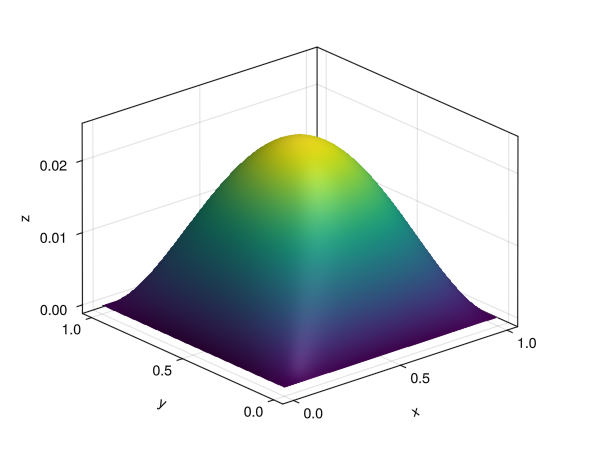

In [14]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(f,64,1)
plot_uh(nodos, triangulos, uh)

Para estos errores voy a necesitar conocer $\nabla u_h$.

In [23]:
function ∇u_h(nodos, triangulos, uh)
    G = zeros(length(nodos[:,1]),2)

    for i in 1:length(nodos[:,1])
        n = 1

        while [true, true, true] == [i != triangulos[n,j] for j in 1:3] #itero hasta encontrar un triangulo que lo contenga
            n += 1
        end
        
        if i == triangulos[n,1]
            a1 = i
            a2 = triangulos[n,2]
            a3 = triangulos[n,3]
        elseif i == triangulos[n,2]
            a1 = i
            a2 = triangulos[n,3]
            a3 = triangulos[n,1]
        else
            a1 = i
            a2 = triangulos[n,1]
            a3 = triangulos[n,2]
        end

        r1 = nodos[a2,:] - nodos[a1,:]
        r2 = nodos[a3,:] - nodos[a1,:]

        norm_r1 = norm(r1)
        norm_r2 = norm(r2)

        A = vcat(r1'/norm_r1, r2'/norm_r2)
        b = [(uh[a2]-uh[a1])/norm_r1; (uh[a3]-uh[a1])/norm_r2]

        G[i,:] = A\b
    end 

    return G
end

∇u_h (generic function with 1 method)

In [24]:
∇u_h(nodos, triangulos, uh)

1024×2 Matrix{Float64}:
  0.0          0.0
 -0.0          0.0
  0.0111429    0.0231384
  0.0103006    0.0334389
 -0.0          0.0334389
  0.0          0.0515527
  0.0          0.0593842
 -0.0          0.0593842
 -0.0          0.0664097
  0.0          0.0780706
  ⋮           
 -0.00622666  -0.0726364
 -0.0         -0.0664097
 -0.00783149  -0.0593842
 -0.0         -0.0515527
  0.0         -0.0334389
 -0.0         -0.0334389
 -0.0         -0.0231384
 -0.0119954   -0.0119954
 -0.0         -0.0

In [25]:
function error_L2(f,N,eps)
    nodos, triangulos, uh = ElementosFinitosRectanguloDir(f,N,eps)
    error = 0.0

    #Calculo el error para cada triangulo
    for T in eachrow(triangulos)

        #Junto los puntos del triangulo
        p = [nodos[i,:] for i in T] 
        
        med_T = abs(det(hcat(p[2]-p[1], p[3]-p[1])))/2

        #Tomo los puntos medio sobre los segmentos del triángulo
        m12 = (p[1].+p[2])./2
        m23 = (p[2].+p[3])./2
        m31 = (p[3].+p[1])./2

        #Veo sus valores en u y uh
        u12 = u(m12[1],m12[2],eps)
        u23 = u(m23[1],m23[2],eps)
        u31 = u(m31[1],m31[2],eps)

        uh12 = (uh[T[1]]+uh[T[2]])/2
        uh23 = (uh[T[2]]+uh[T[3]])/2
        uh31 = (uh[T[3]]+uh[T[1]])/2
        
        error += (med_T/3)*((u12-uh12)^2 + (u23-uh23)^2 + (u31-uh31)^2)
    end
    
    return sqrt(error)
    
end 

error_L2 (generic function with 1 method)

In [ ]:
function ∇u(x,y,ε)
    u_x = (1-exp(-(1-y)/ε))*(1-exp(y/ε))*(exp(-(x+y)/ε))*(exp((2*x-1)/ε)-1)/ε
    u_y = (1-exp(-(1-x)/ε))*(1-exp(x/ε))*(exp(-(x+y)/ε))*(exp((2*y-1)/ε)-1)/ε
    return [u_x,u_y]
end


∇u (generic function with 1 method)

In [37]:
function error_L2_grad(f,N,eps)
    nodos, triangulos, uh = ElementosFinitosRectanguloDir(f,N,eps)
    ∇uh = ∇u_h(nodos, triangulos, uh)
    error = 0.0

    #Calculo el error para cada triangulo
    for T in eachrow(triangulos)

        #Junto los puntos del triangulo
        p = [nodos[i,:] for i in T] 
        
        med_T = abs(det(hcat(p[2]-p[1], p[3]-p[1])))/2

        #Tomo los puntos medio sobre los segmentos del triángulo
        m12 = (p[1].+p[2])./2
        m23 = (p[2].+p[3])./2
        m31 = (p[3].+p[1])./2

        #Veo sus valores en u y uh
        ∇u12 = ∇u(m12[1],m12[2],eps)
        ∇u23 = ∇u(m23[1],m23[2],eps)
        ∇u31 = ∇u(m31[1],m31[2],eps)

        ∇uh12 = (∇uh[T[1],:]+∇uh[T[2],:])/2
        ∇uh23 = (∇uh[T[2],:]+∇uh[T[3],:])/2
        ∇uh31 = (∇uh[T[3],:]+∇uh[T[1],:])/2
        
        error += (med_T/3)*(norm(∇u12-∇uh12)^2 + norm(∇u23-∇uh23)^2 + norm(∇u31-∇uh31)^2)
    
    end

    return sqrt(error)
end


error_L2_grad (generic function with 1 method)

In [38]:
function error_H1(f,N,eps)
    return sqrt((error_L2(f,N,eps))^2 + (error_L2_grad(f,N,eps))^2)
end

error_H1 (generic function with 1 method)

In [39]:
function orden_de_convergencia(vector_N,f,eps)
    h = 1 ./ vector_N
    errores_L2 = Float64[]
    errores_H1 = Float64[]

    for N in vector_N
        errorL2 = error_L2(f,N,eps)
        errorH1 = error_H1(f,N,eps)
        push!(errores_L2,errorL2)
        push!(errores_H1,errorH1)
    end

    pL2 = fit(log.(h),log.(errores_L2),1)
    pH1 = fit(log.(h),log.(errores_H1),1)
    orden_L2 = coeffs(pL2)[2]
    orden_H1 = coeffs(pH1)[2]

    println("Orden L2: ",orden_L2)
    println("Orden H1: ",orden_H1)

    Plots.plot(log.(h),log.(errores_L2),label="error L2",marker=:o)
    Plots.plot!(log.(h),log.(errores_H1),label="error H1",marker=:s)
    Plots.plot!(xlabel="log(h)",ylabel="log(error)",legend=:right,title="Convergencia")
end

orden_de_convergencia (generic function with 1 method)

Orden L2: 2.1016465003999687
Orden H1: 1.0315665790281392


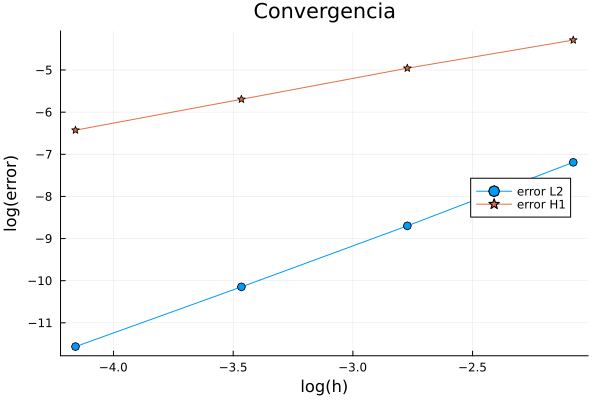

In [42]:
orden_de_convergencia([8,16,32,64],f,1)

Orden L2: 2.0550233140858016
Orden H1: 0.013298880909909326


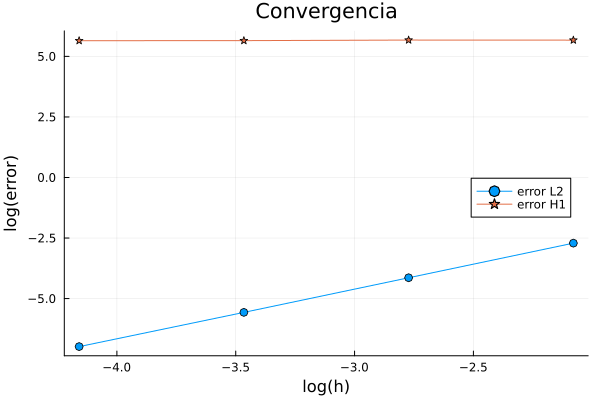

In [40]:
orden_de_convergencia([8,16,32,64],f,0.1)

Orden L2: 1.0760753658792626
Orden H1: -4.75138855433833


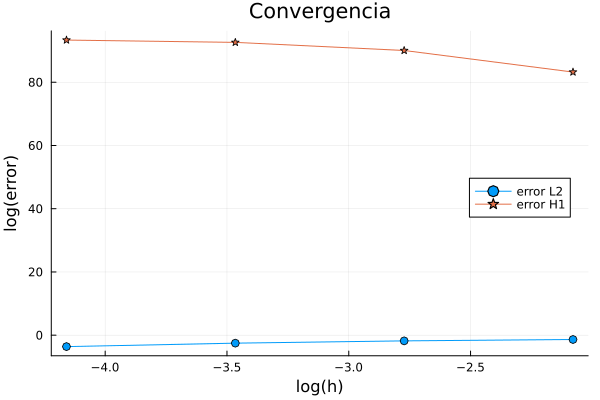

In [23]:
orden_de_convergencia([8,16,32,64],f,0.01)

## Ejercicio 5

In [24]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(u,64,1)
fig = plot_uh(nodos, triangulos, uh)
display(fig)

GLMakie.Screen(...)

In [25]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(u,64,0.1)
fig = plot_uh(nodos, triangulos, uh)
display(fig)

GLMakie.Screen(...)

In [26]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(u,64,0.01)
fig = plot_uh(nodos, triangulos, uh)
display(fig)

GLMakie.Screen(...)

In [ ]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(u,64,0.001)
fig = plot_uh(nodos, triangulos, uh)
display(fig)

GLMakie.Screen(...)

: 

Los gráficos de la solución análitica son muy similares pero a medida que el $\varepsilon$ se va achicando, la función deja de ser tan suave, pegando saltos demaciado grandes que los triángulos no cargan por lo que la discretización comienza a fallar. Tal vez agrandando la malla la discretización tome un mejor gráfico.

In [ ]:
nodos, triangulos, uh = ElementosFinitosRectanguloDir(u,518,0.001)
fig = plot_uh(nodos, triangulos, uh)
display(fig)